In [1]:
import modules.loss as loss_module
import modules.metrics as metrics
import modules.utils as utils
import config

import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2

# Target and Label

$$
target = [x_{Cell}, y_{Cell}, w, h, 1, smoke, fire] 
$$

$$
label = [x_{Cell_1}, y_{Cell_1}, w_{1}, h_{1}, score_{1}, x_{Cell_2}, y_{Cell_2}, w_{2}, h_{2}, score_{2}, smoke, fire]
$$

In [2]:
target_shape = (config.S, config.S, 5 + config.C)
target_1 = torch.tensor(np.zeros(target_shape), dtype=torch.float32).unsqueeze(dim=0)

target_2 = torch.tensor(np.zeros(target_shape), dtype=torch.float32).unsqueeze(dim=0)

target_batch = torch.concat([target_1, target_2])

pred_shape = (config.S, config.S, 5*config.B + config.C)
pred_1 = torch.tensor(np.zeros(pred_shape), dtype=torch.float32).unsqueeze(dim=0)

pred_2 = torch.tensor(np.zeros(pred_shape), dtype=torch.float32).unsqueeze(dim=0)

pred_batch = torch.concat([pred_1, pred_2])

In [3]:
print(f'Target batch shape: {target_batch.shape}')
print(f'Label batch shape: {pred_batch.shape}')

Target batch shape: torch.Size([2, 7, 7, 7])
Label batch shape: torch.Size([2, 7, 7, 12])


### Create Manual Targets and Labels

### Targets

In [4]:
# 1st target
target_batch[0, 2, 3] = torch.tensor(np.array([0.5, 0.4, 0.25, 0.15, 1, 1, 0])) # Smoke
target_batch[0, 4, 5] = torch.tensor(np.array([0.25, 0.75, 0.6, 0.4, 1, 0, 1])) # Fire

# 2nd target
target_batch[1, 6, 6] = torch.tensor(np.array([0.5, 0.4, 0.1, 0.1, 1, 1, 0])) # Smoke
target_batch[1, 0, 0] = torch.tensor(np.array([0.8, 0.9, 0.2, 0.2, 1, 0, 1])) # Fire

### Plot Target Images Over White Background

In [5]:
img = ( np.ones((config.IMG_H, config.IMG_W, 3), dtype=np.float32) *255 ) / 256
img = torch.tensor(img).permute(2, 0, 1)

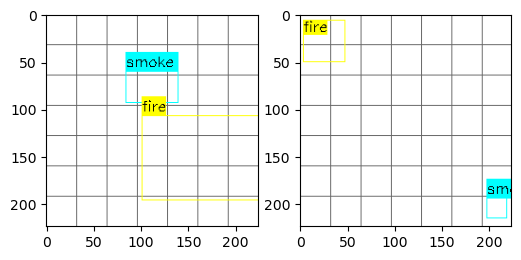

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# 1st Target
pic_target_1 = utils.plot_dataset_img(img.detach().clone(), target_batch[0], grid=True)
plt.subplot(1, 2, 1)
ax[0].imshow(pic_target_1)

# 1st Target
pic_target_2 = utils.plot_dataset_img(img.detach().clone(), target_batch[1], grid=True)
plt.subplot(1, 2, 2)
ax[1].imshow(pic_target_2)

plt.show()

# Labels

In [7]:
# 1st label: 2BB
pred_batch[0, 2, 3, :5] = torch.tensor(np.array([0.5, 0.4, 0.25, 0.15, 0.8])) # bbox 1: best
pred_batch[0, 2, 3, 5:10] = torch.tensor(np.array([0.51, 0.4, 0.25, 0.15, 0.9])) # bbox 2
pred_batch[0, 2, 3, 10:12] = torch.tensor(np.array([1, 0])) # Smoke

# Threshold not reached: 0.5
pred_batch[0, 4, 5, :5] = torch.tensor(np.array([0.26, 0.75, 0.1, 0.1, 0.7])) # Fire
pred_batch[0, 4, 5, 5:10] = torch.tensor(np.array([0.25, 0.75, 0.6, 0.4, 0.3])) # Fire: best
pred_batch[0, 4, 5, 10:12] = torch.tensor(np.array([0, 1])) # Fire

# 2nd label: 2BB -> 1 detection is wrong
pred_batch[1, 6, 6, :5] = torch.tensor(np.array([0.5, 0.4, 0.1, 0.1, 0.7])) # Smoke
pred_batch[1, 6, 6, 5:10] = torch.tensor(np.array([0.53, 0.4, 0.1, 0.1, 0.2])) # Smoke
pred_batch[1, 6, 6, 10:12] = torch.tensor(np.array([1, 0])) # Smoke

pred_batch[1, 0, 0, :5] = torch.tensor(np.array([0.81, 0.9, 0.2, 0.2, 0.6])) # Fire
pred_batch[1, 0, 0, 5:10] = torch.tensor(np.array([0.8, 0.9, 0.2, 0.2, 0.6])) # Fire
pred_batch[1, 0, 0, 10:12] = torch.tensor(np.array([0, 1])) # Smoke -> wrong class, Fire -> right class. Testing

# Adding a Prediction to 2nd batch, to test No Obj Loss
pred_batch[1, 3, 3, :5] = torch.tensor(np.array([0.81, 0.9, 0.2, 0.2, 0.71])) # Fire
pred_batch[1, 3, 3, 5:10] = torch.tensor(np.array([0.8, 0.9, 0.2, 0.2, 0.51])) # Fire
pred_batch[1, 3, 3, 10:12] = torch.tensor(np.array([0, 1])) 

Results change depending on the order high -> down of the scores.

### Get BBoxes from Model Out

In [8]:
def get_2_bboxes_from_model_output(out_mtx):
    '''
    Receives a label_mtx, as yielded by dataset or dataloader and returns a list of bounding boxes.
    
    Arguments:
        - label_mtx
    
    Returns:
        - bboxes_list: list with all cells containing score = 1
            [xcell, ycell, w, h, score, smoke, fire] -> [x, y, w, h, 1, smoke, fire]
    '''

    c2b_mtx = np.zeros((config.S, config.S, 2))
    for j in range(config.S):
        for i in range(config.S):
            c2b_mtx[i, j, 0] = j
            c2b_mtx[i, j, 1] = i

    out_mtx = out_mtx.numpy()
    out_xy_1 = out_mtx[..., :2]
    out_xy_2 = out_mtx[..., 5:7]
    out_rest_1 = out_mtx[..., 2:5]
    out_rest_2 = out_mtx[..., 7:10]
    out_classes = out_mtx[..., 10:12]

    c2b_xy_1 = (c2b_mtx+out_xy_1)/config.S
    c2b_xy_2 = (c2b_mtx+out_xy_2)/config.S

    out_1 = np.concatenate((c2b_xy_1, out_rest_1, out_classes), axis=-1)
    out_2 = np.concatenate((c2b_xy_2, out_rest_2, out_classes), axis=-1)
    #print(f'Out1 shape\n {out_1.shape}')

    bboxes_list_1 = np.reshape(out_1, (config.S*config.S, 5+config.C))
    bboxes_list_2 = np.reshape(out_2, (config.S*config.S, 5+config.C))
    
    bboxes_list = np.concatenate((bboxes_list_1, bboxes_list_2), axis=0)

    bboxes_list = [bbox for bbox in bboxes_list.tolist() if bbox[4]>=config.SCORE_THRESHOLD]

    return bboxes_list

In [9]:
bboxes_pred_batch_1 = get_2_bboxes_from_model_output(pred_batch[0])
for box in bboxes_pred_batch_1:
    print(box)

[0.5, 0.3428571437086378, 0.25, 0.15000000596046448, 0.800000011920929, 1.0, 0.0]
[0.7514285700661796, 0.6785714285714286, 0.10000000149011612, 0.10000000149011612, 0.699999988079071, 0.0, 1.0]
[0.5014285700661796, 0.3428571437086378, 0.25, 0.15000000596046448, 0.8999999761581421, 1.0, 0.0]


### Plot Out BBoxes Before NMS

In [10]:
def plot_grid(img):
    '''
    Plot grid on top of the picture
    '''
      
    cell_size = int(config.IMG_W / config.S)
    
    # Draw horizontal lines
    for i in range(1, config.S):
        cv2.line(img, (0, cell_size*i), (config.IMG_W-1, cell_size*i), config.GRID_COLOR, 1)
    # Draw vertical lines
    for j in range(1, config.S):
        cv2.line(img, (cell_size*j, 0), (cell_size*j, config.IMG_H-1), config.GRID_COLOR, 1)
        
    return img

In [11]:
def plot_model_out_img(img, out_mtx, grid=False):
    '''
    It draws the bounding boxes over the image.

    Arguments:
        - ori_img: original image with no modification or letterbox
        - label_mtx: [xcell, ycell, w, h, score=1, smoke, fire]
        - grid: plot grid over the image

    Returns:
        - pic: picture with bounding boxes on top of original picture
    '''

    # NEVER remove copy() or use np.ascontiguousarray()
    # Convert pytorch tensor to numpy
    img = img.permute(1, 2, 0) * 256
    img = img.numpy().astype(np.uint8).copy()   
       
    if grid == True:
        img = plot_grid(img)
    
    bboxes = get_2_bboxes_from_model_output(out_mtx)

    for i,(xc, yc, w, h, score, smoke, fire) in enumerate(bboxes):
        xmin, ymin, xmax, ymax = xc - w/2, yc - h/2, xc + w/2, yc + h/2
        box = np.array([xmin, ymin, xmax, ymax]).astype(np.float32)
        box[0] = box[0]*config.IMG_W
        np.clip(box[0], 0, None)
        box[1] = box[1]*config.IMG_H
        np.clip(box[1], 0, None)
        box[2] = box[2]*config.IMG_W - 1 # avoid out of limits due to rounding
        box[3] = box[3]*config.IMG_H - 1 # avoid out of limits due to rounding
        box = box.round().astype(np.int32).tolist()
        #print(f'Box after conversion\n{box}')
        if smoke == 1:
            class_id = 0
        elif fire == 1:
            class_id = 1
        else:
            print("Wrong Class ID")
        name = config.CLASSES[class_id]
        color = config.BBOX_COLORS[name]
        name += f'{score:.4f}'
        cv2.rectangle(img, box[:2], box[2:], color, 1) 
        if box[1] < 30:
            if class_id == 0:
                cv2.rectangle(img, [box[0], box[1]+15], [box[0]+55, box[1]], color, -1) 
            else:
                cv2.rectangle(img, [box[0], box[1]+15], [box[0]+25, box[1]], color, -1) 
            cv2.putText(img,name,(box[0], box[1] + 12),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, [0, 0, 0],
                        thickness=1)  # 0.5 -> font size
        else:
            if class_id == 0:
                cv2.rectangle(img, [box[0], box[1]-20], [box[0]+55, box[1]], color, -1) 
            else:
                cv2.rectangle(img, [box[0], box[1]-20], [box[0]+25, box[1]], color, -1) 
            cv2.putText(img,name,(box[0], box[1] - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, [0, 0, 0],
                        thickness=1)  # 0.5 -> font size

    return img

Scores and Boxes Overlap when 2 BBoxes confidence is above score threshold

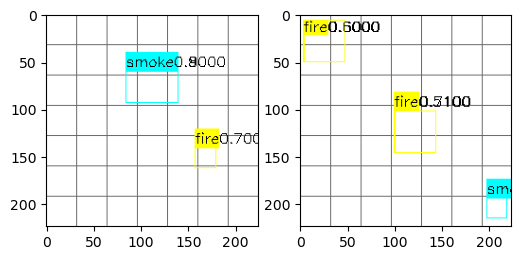

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))

# 1st Target
pic_label_1 = plot_model_out_img(img.detach().clone(), pred_batch[0], grid=True)
plt.subplot(1, 2, 1)
ax[0].imshow(pic_label_1)

# 1st Target
pic_label_2 = plot_model_out_img(img.detach().clone(), pred_batch[1], grid=True)
plt.subplot(1, 2, 2)
ax[1].imshow(pic_label_2)

plt.show()

# Loss Results

In [13]:
loss_fn = loss_module.YoloLoss_2BBox()

In [14]:
losses = loss_fn(
    ground_truth=target_batch,
    predictions=pred_batch)

print(losses)
print(loss_fn.get_last_losses())

tensor(1.1621)
(0.0, 5.67501601267395e-11, 0.7799999713897705, 0.382099986076355, 0.0)


It is normal that XY losses is 0, as IOU is better for boxes with less score, so it is preferred.

On the other hand, during real predictions, higher score is preferred.

# mAP, AP and AR Metrics

### Target Boxes

In [15]:
target_boxes = metrics.get_true_boxes(target_batch[0])
print(target_boxes)

[{'boxes': tensor([[ 84.0000,  60.0000, 140.0000,  93.6000],
        [100.8000, 107.2000, 235.2000, 196.8000]], device='cuda:0'), 'labels': tensor([0, 1], device='cuda:0', dtype=torch.int32)}]


Check true boxes are ok:
- Original xyxy coordinates
$$
x_{min} = 84\\
y_{min} = 60\\
x_{max} = 140\\
y_{max} = 93.6\\
$$
- XYWH coordinates
$$
x_{center} = 112\\
y_{center} = 76.8\\
w = 56\\
h = 33.6\\
$$
- Yolo coordinates: normalization by IMG_H, IMG_W
$$
x_{center} = 0.5\\
y_{center} = 0.3429\\
w = 0.25\\
h = 0.15\\
$$
- Encode to cell coordinates
$$
j = int(x_{center}*7) = 3\\
x_{cell} = x_{center}*7 - j = 3.5 - 3 = 0.5\\
i = int(y_{center}*7) = 2\\
y_{cell} = y_{center}*7 - i = 2.4 - 2 = 0.4\\
w = 0.25\\
h = 0.15\\
$$

### Predicted Boxes

In [16]:
predicted_boxes = metrics.get_pred_boxes(pred_batch[0])
print(predicted_boxes)

[{'boxes': tensor([[ 84.3200,  60.0000, 140.3200,  93.6000],
        [157.1200, 140.8000, 179.5200, 163.2000]], device='cuda:0'), 'scores': tensor([0.9000, 0.7000], device='cuda:0'), 'labels': tensor([0, 1], device='cuda:0', dtype=torch.int32)}]


## Compute 1st Batch

Syntax: 
- metric.update(preds, target)

In [17]:
metrics.map_metric.update(
    preds=predicted_boxes,
    target=target_boxes)

In [18]:
mAP_results = metrics.map_metric.compute()
print(mAP_results)

{'map': tensor(0.5000), 'map_50': tensor(0.5000), 'map_75': tensor(-1.), 'map_small': tensor(-1.), 'map_medium': tensor(1.), 'map_large': tensor(0.), 'mar_1': tensor(0.5000), 'mar_10': tensor(0.5000), 'mar_100': tensor(0.5000), 'mar_small': tensor(-1.), 'mar_medium': tensor(1.), 'mar_large': tensor(0.), 'map_per_class': tensor([1., 0.]), 'mar_100_per_class': tensor([1., 0.]), 'classes': tensor([0, 1], dtype=torch.int32)}


## Compute 1st and 2nd Batch

In [19]:
metrics.map_metric.reset()

### Target Boxes

In [20]:
target_boxes_1 = metrics.get_true_boxes(target_batch[0])
print(target_boxes_1)

target_boxes_2 = metrics.get_true_boxes(target_batch[1])
print(target_boxes_2)

[{'boxes': tensor([[ 84.0000,  60.0000, 140.0000,  93.6000],
        [100.8000, 107.2000, 235.2000, 196.8000]], device='cuda:0'), 'labels': tensor([0, 1], device='cuda:0', dtype=torch.int32)}]
[{'boxes': tensor([[  3.2000,   6.4000,  48.0000,  51.2000],
        [196.8000, 193.6000, 219.2000, 216.0000]], device='cuda:0'), 'labels': tensor([1, 0], device='cuda:0', dtype=torch.int32)}]


### Predicted Boxes

In [21]:
predicted_boxes_1 = metrics.get_pred_boxes(pred_batch[0])
print(predicted_boxes_1)

predicted_boxes_2 = metrics.get_pred_boxes(pred_batch[1])
print(predicted_boxes_2)

[{'boxes': tensor([[ 84.3200,  60.0000, 140.3200,  93.6000],
        [157.1200, 140.8000, 179.5200, 163.2000]], device='cuda:0'), 'scores': tensor([0.9000, 0.7000], device='cuda:0'), 'labels': tensor([0, 1], device='cuda:0', dtype=torch.int32)}]
[{'boxes': tensor([[ 99.5200, 102.4000, 144.3200, 147.2000],
        [196.8000, 193.6000, 219.2000, 216.0000],
        [  3.5200,   6.4000,  48.3200,  51.2000]], device='cuda:0'), 'scores': tensor([0.7100, 0.7000, 0.6000], device='cuda:0'), 'labels': tensor([1, 0, 1], device='cuda:0', dtype=torch.int32)}]


### Compute

In [22]:
metrics.map_metric.update(
    preds=predicted_boxes_1,
    target=target_boxes_1)

metrics.map_metric.update(
    preds=predicted_boxes_2,
    target=target_boxes_2)

mAP_results = metrics.map_metric.compute()
print(mAP_results)

{'map': tensor(0.5842), 'map_50': tensor(0.5842), 'map_75': tensor(-1.), 'map_small': tensor(1.), 'map_medium': tensor(0.7500), 'map_large': tensor(0.), 'mar_1': tensor(0.5000), 'mar_10': tensor(0.7500), 'mar_100': tensor(0.7500), 'mar_small': tensor(1.), 'mar_medium': tensor(1.), 'mar_large': tensor(0.), 'map_per_class': tensor([1.0000, 0.1683]), 'mar_100_per_class': tensor([1.0000, 0.5000]), 'classes': tensor([0, 1], dtype=torch.int32)}
